In [1]:
import sys
import os

# Add project root to Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, project_root)

print("Project root added to path:", project_root)

Project root added to path: /Users/krishna/Desktop/NIRANJAN/rl-derivative_hedging


In [2]:
%pip install yfinance
%pip install scipy
%pip install matplotlib
%pip install stable-baselines3 gymnasium

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import yfinance as yf
data = yf.download("SPY", start="2018-01-01", end="2023-01-01")
print(data.head())

/Users/krishna/Desktop/NIRANJAN/rl-derivative_hedging/.venv/lib/python3.13/site-packages/yfinance/scrapers/history.py:201: Pandas4Warning: Timestamp.utcnow is deprecated and will be removed in a future version. Use Timestamp.now('UTC') instead.
  dt_now = pd.Timestamp.utcnow()
[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open    Volume
Ticker             SPY         SPY         SPY         SPY       SPY
Date                                                                
2018-01-02  237.208206  237.243516  235.999090  236.387423  86655700
2018-01-03  238.708618  238.858667  237.375929  237.375929  90070400
2018-01-04  239.714737  240.200166  238.770408  239.352907  80636400
2018-01-05  241.312195  241.435741  240.014816  240.509053  83524000
2018-01-08  241.753387  241.912243  240.923770  241.215006  57319200


In [4]:
print(data.shape)
print(data.columns)

(1259, 5)
MultiIndex([( 'Close', 'SPY'),
            (  'High', 'SPY'),
            (   'Low', 'SPY'),
            (  'Open', 'SPY'),
            ('Volume', 'SPY')],
           names=['Price', 'Ticker'])


In [5]:
from pricing.black_scholes import bs_call_price, bs_delta, bs_gamma

S = 100
K = 100
T = 1.0
r = 0.05
sigma = 0.2

print("Call Price:", bs_call_price(S, K, T, r, sigma))
print("Delta:", bs_delta(S, K, T, r, sigma))
print("Gamma:", bs_gamma(S, K, T, r, sigma))

Call Price: 10.450583572185565
Delta: 0.6368306511756191
Gamma: 0.018762017345846895


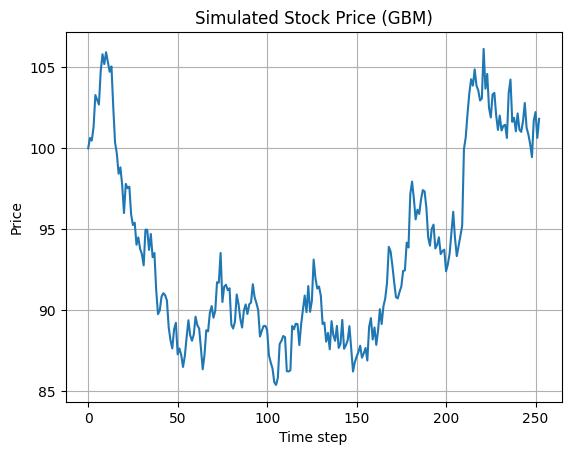

In [6]:
from simulator.gbm import simulate_gbm
import matplotlib.pyplot as plt

prices = simulate_gbm(
    S0=100,
    mu=0.05,
    sigma=0.2,
    T=1.0,
    steps=252,
    seed=42
)

plt.plot(prices)
plt.title("Simulated Stock Price (GBM)")
plt.xlabel("Time step")
plt.ylabel("Price")
plt.grid(True)
plt.show()

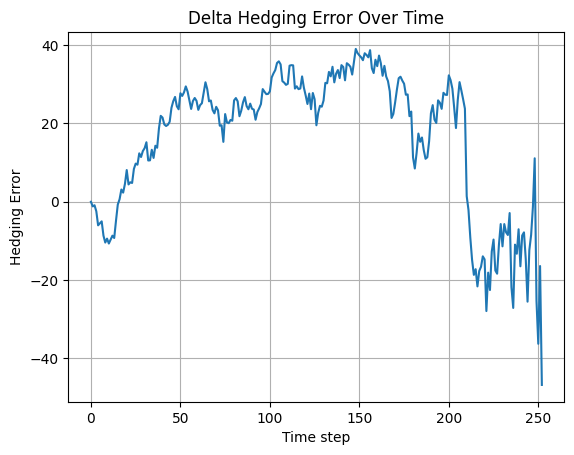

In [7]:
from simulator.gbm import simulate_gbm
from benchmarks.delta_hedging import delta_hedge
import matplotlib.pyplot as plt

# Simulate stock prices
prices = simulate_gbm(
    S0=100,
    mu=0.05,
    sigma=0.2,
    T=1.0,
    steps=252,
    seed=42
)

# Run delta hedging
result = delta_hedge(
    prices=prices,
    K=100,
    r=0.05,
    sigma=0.2,
    T=1.0
)

# Plot hedging error
plt.plot(result["hedging_error"])
plt.title("Delta Hedging Error Over Time")
plt.xlabel("Time step")
plt.ylabel("Hedging Error")
plt.grid(True)
plt.show()

In [9]:
from env.hedging_env import HedgingEnv
env = HedgingEnv()

In [14]:
obs, _ = env.reset()

print("Initial state:", obs)
print("=" * 50)

for step in range(3):
    action = env.action_space.sample()  # RANDOM action
    obs, reward, done, _, _ = env.step(action)

    print(f"Step {step}")
    print("Action taken:", action)
    print("Reward received:", reward)
    print("New state:", obs)
    print("-" * 50)

    if done:
        break

Initial state: [1.0000000e+02 6.3683063e-01 1.8762017e-02 1.0000000e+00 2.0000000e-01
 0.0000000e+00]
Step 0
Action taken: [0.13213834]
Reward received: -0.2292278032871647
New state: [9.9112755e+01 6.1968589e-01 1.9251270e-02 9.9603176e-01 2.0000000e-01
 1.3213834e-01]
--------------------------------------------------
Step 1
Action taken: [0.77446204]
Reward received: -0.36956551365747053
New state: [9.6820717e+01 5.7394135e-01 2.0328056e-02 9.9206346e-01 2.0000000e-01
 9.0660036e-01]
--------------------------------------------------
Step 2
Action taken: [-0.5796449]
Reward received: -0.010514619021231027
New state: [9.6731430e+01 5.7171947e-01 2.0408846e-02 9.8809522e-01 2.0000000e-01
 3.2695547e-01]
--------------------------------------------------


In [15]:
from stable_baselines3 import PPO
from env.hedging_env import HedgingEnv

env = HedgingEnv()

model = PPO(
    policy="MlpPolicy",
    env=env,
    verbose=1
)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [16]:
model.learn(total_timesteps=1000)

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 252       |
|    ep_rew_mean     | -2.78e+04 |
| time/              |           |
|    fps             | 2423      |
|    iterations      | 1         |
|    time_elapsed    | 0         |
|    total_timesteps | 2048      |
----------------------------------


In [17]:
obs, _ = env.reset()

print("=== PPO Agent Acting ===")

for step in range(5):
    action, _ = model.predict(obs)
    obs, reward, done, _, _ = env.step(action)

    print(f"Step {step}")
    print("Action:", action)
    print("Reward:", reward)
    print("State:", obs)
    print("-" * 40)

    if done:
        break

=== PPO Agent Acting ===
Step 0
Action: [-1.]
Reward: -11.459278448829062
State: [ 1.0211981e+02  6.7522824e-01  1.7652156e-02  9.9603176e-01
  2.0000000e-01 -1.0000000e+00]
----------------------------------------
Step 1
Action: [1.]
Reward: -0.0873217861885045
State: [1.02742256e+02 6.85954213e-01 1.73342880e-02 9.92063463e-01
 2.00000003e-01 0.00000000e+00]
----------------------------------------
Step 2
Action: [-0.2491358]
Reward: -7.2522248175493464
State: [ 9.9836212e+01  6.3294554e-01  1.8973166e-02  9.8809522e-01
  2.0000000e-01 -2.4913581e-01]
----------------------------------------
Step 3
Action: [0.8993937]
Reward: -0.003609386162136678
State: [9.8186874e+01 6.0063374e-01 1.9823596e-02 9.8412699e-01 2.0000000e-01
 6.5025789e-01]
----------------------------------------
Step 4
Action: [-0.03736528]
Reward: -0.00038672484885551053
State: [9.6532173e+01 5.6681216e-01 2.0578407e-02 9.8015875e-01 2.0000000e-01
 6.1289257e-01]
----------------------------------------


In [26]:
import numpy as np
from simulator.gbm import simulate_gbm

S0 = 100
K = 100
r = 0.05
sigma = 0.2
T = 1.0
steps = 252

prices = simulate_gbm(
    S0=S0,
    mu=r,
    sigma=sigma,
    T=T,
    steps=steps,
    seed=42
)

In [27]:
from benchmarks.delta_hedging import delta_hedge

delta_result = delta_hedge(
    prices=prices,
    K=K,
    r=r,
    sigma=sigma,
    T=T
)

delta_error = delta_result["hedging_error"]

In [28]:
from env.hedging_env import HedgingEnv

env = HedgingEnv(
    S0=S0,
    K=K,
    r=r,
    sigma=sigma,
    T=T,
    steps=steps
)

obs, _ = env.reset()
random_errors = []

for _ in range(steps):
    action = env.action_space.sample()
    obs, reward, done, _, _ = env.step(action)
    random_errors.append(-reward)  # proxy for instability
    if done:
        break

random_errors = np.array(random_errors)

In [33]:
obs, _ = env.reset()
ppo_errors = []

for _ in range(steps):
    action, _ = model.predict(obs)
    obs, reward, done, _, _ = env.step(action)
    ppo_errors.append(-reward)
    if done:
        break

ppo_errors = np.array(ppo_errors)

In [37]:
delta_abs = np.abs(delta_error)
random_abs = np.sqrt(random_errors)   # undo squaring
ppo_abs = np.sqrt(ppo_errors)



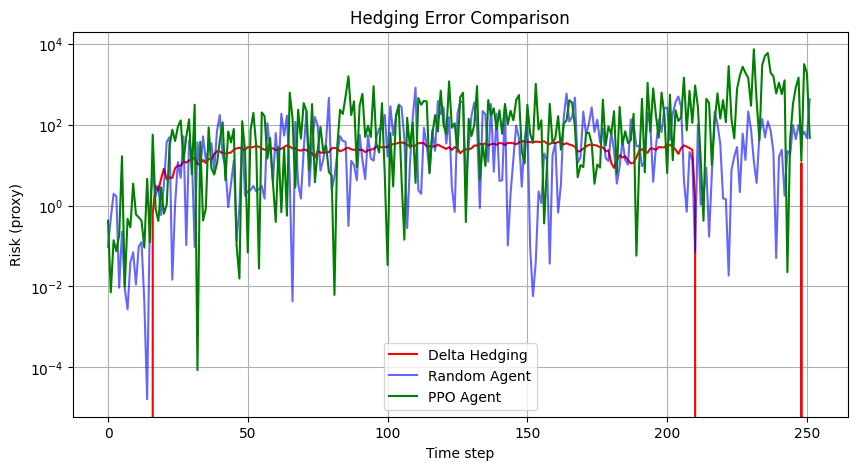

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(delta_error, label="Delta Hedging", color = "red")
plt.plot(random_errors, label="Random Agent", alpha=0.6, color = "blue")
plt.plot(ppo_errors, label="PPO Agent", color = "green")
plt.legend()
plt.title("Hedging Error Comparison")
plt.xlabel("Time step")
plt.ylabel("Risk (proxy)")
plt.grid(True)
plt.yscale("log")
plt.show()

In [24]:
def risk_summary(x):
    return {
        "Mean": np.mean(x),
        "Std": np.std(x),
        "Max": np.max(x)
    }

print("Random:", risk_summary(random_errors))
print("Delta :", risk_summary(delta_error))
print("PPO   :", risk_summary(ppo_errors))

Random: {'Mean': np.float64(8.04581507115426), 'Std': np.float64(20.415513061535695), 'Max': np.float64(246.49269757817532)}
Delta : {'Mean': np.float64(16.35679265318743), 'Std': np.float64(17.800816143671618), 'Max': np.float64(39.01989480721396)}
PPO   : {'Mean': np.float64(331.96583359618796), 'Std': np.float64(852.1903059020989), 'Max': np.float64(6869.272173931326)}
